<a href="https://colab.research.google.com/github/mille-s/WikipediaPage_Generator/blob/main/Wikipedia_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Prepare repo

In [1]:
# Run this cell to download and unzip the working folder and install Java 8

from IPython.display import clear_output, HTML, display
import os
import shutil

# clone main repo
! git clone https://github.com/mille-s/DCU_TCD-FORGe_WebNLG23.git
# Delete locally to avoid confusion
! rm 'DCU_TCD-FORGe_WebNLG23/DCU_TCD_FORGe_WebNLG23.ipynb'

# clone M-FleNS repo (generation pipeline)
! git clone https://github.com/mille-s/M-FleNS_NLG-Pipeline.git
# Delete locally to avoid confusion
! rm 'M-FleNS_NLG-Pipeline/M_FleNS_pipe_v2.ipynb'

# Download FORGe
# Version used for WebNLG (fails to generate a few structures of the training data)
# ! gdown 1lsh8pwUp9mc0Z_aFbSy1WTIpSx9YwFFD
# ! unzip /content/FORGe_colab_v3_WebNLG.zip
# Version used for Mod-D2T (minor improvements on WebNLG)
! gdown 196w_EtORTkR3idaXDMq0xl3pOtBrGbiE
! unzip /content/FORGe_colab_v4.zip

# Download triple to predArg conversion
triple2predArg = 'triples2predArg'
os.makedirs(triple2predArg)
! gdown 1q2MXCvWpNMFBhp40Ssylmu2RDsfbJhWb
! unzip 'triples2predArg.zip' -d {triple2predArg}
! rm 'triples2predArg.zip'

# Download Morphology generator
! gdown 1vk1utEjeZ_2YO1H20DPDTjVSevgRJNM_
morph_folder_name = 'test_irish_morph_gen_v5.0'
zip_name = morph_folder_name+'.zip'
! unzip {zip_name}

morph_input_folder = '/content/'+morph_folder_name+'/Inputs'
morph_output_folder = '/content/'+morph_folder_name+'/Outputs'
os.makedirs(morph_input_folder)
os.makedirs(morph_output_folder)

# Make morphology flookup executable
! 7z a -sfx {morph_folder_name}'/flookup.exe' {morph_folder_name}'/flookup'
! chmod 755 {morph_folder_name}'/flookup'

# Download mock Wikipedia headers
! gdown 1MV9y3yvBDtVbLXKYAFSkGPjoax2krwad
! gdown 13-X_PRejn3pavQ4f4ltAOvZlklluS1QV
shutil.move('/content/wikipedia-header.png', triple2predArg)
shutil.move('/content/wikipedia-subheader.png', triple2predArg)

# Install SPARQLWrapper and download list of properties
! pip install SPARQLWrapper
! gdown 1zM1ikqqdyEeT-HHYlN6Grj3f7BoQYcs3
props_list_path = '/content/DCU_TCD-FORGe_WebNLG23/sorted_properties.txt'
shutil.move('/content/sorted_properties.txt', props_list_path)

# Clean
! rm '/content/FORGe_colab_v3_WebNLG.zip'
! rm '/content/FORGe_colab_v4.zip'
! rm '/content/test_irish_morph_gen_v5.0.zip'
clear_output()
print('Working folder ready!\n--------------\nInstalling Java 8...\n')

# Switch to Java 1.8 (needed for FORGe to run correctly)
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
  !java -version       #check java version
install_java()

# To wrap texts in cells
def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))

get_ipython().events.register('pre_run_cell', set_css)

Working folder ready!
--------------
Installing Java 8...

update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java to provide /usr/bin/java (java) in manual mode
openjdk version "1.8.0_392"
OpenJDK Runtime Environment (build 1.8.0_392-8u392-ga-1~22.04-b08)
OpenJDK 64-Bit Server VM (build 25.392-b08, mixed mode)


# Step 2: Get DBpedia properties associated with an entity name

In [21]:
# @title Set parameters
############# Type entity #############
name = 'Marie Curie'#@param {type:"string"}
entity_name = ('_').join(name.split(' '))

############# Select class #############
category = 'Scientist'#@param['Unknown', 'Airport', 'Artist', 'Astronaut', 'Athlete', 'Building', 'CelestialBody', 'City', 'ComicsCharacter', 'Company', 'Film', 'Food', 'MeanOfTransportation', 'Monument', 'MusicalWork', 'Politician', 'Scientist', 'SportsTeam', 'University', 'WrittenWork']
input_category = category

############# Select language #############
language = 'GA' #@param['EN', 'ES', 'GA']

############# Triple source #############
# To select where to get the triples from. Ontology is supposed to be cleaner but have less coverage.
triple_source = 'Infobox' #@param['Ontology', 'Infobox']

############# Set properties to discard #############
ignore_properties = 'width, title'#@param {type:"string"}
ignore_properties_input = ignore_properties.split(',')
ignore_properties_list = []
for ignored_property in ignore_properties_input:
  ignore_properties_list.append(ignored_property.strip())
# print(ignore_properties_list)

############# Select module grouping #############
# Group consecutive modules for the same system or call each module separately.
# Select 'no' to get all intermediate representations, 'yes' if you're only interested in the output.
generate_intermediate_representations = 'no' #@param['yes', 'no']
group_modules_prm = ''
if generate_intermediate_representations == 'yes':
  group_modules_prm = 'no'
else:
  group_modules_prm = 'yes'

############# Select dataset split #############
split = "test" #@param['dev', 'test','train','ukn']

# print('Parameters set!')
# print(entity_name)
# print(input_category)
# print(ignore_properties_list)

In [3]:
# @title Get DBpedia properties
# Query DBpedia for a given entity
# From ChatGPT. Prompt: "Thanks! Now please write a sparql query that can be used in Python to get all the properties related to Olga Bondareva on DBpedia. For example, birthDate, birthPlace, etc."
from SPARQLWrapper import SPARQLWrapper, JSON
from xml.dom import minidom
import os
import re
import codecs
import pandas as pd
import ipywidgets as widgets
from ipywidgets import Layout

# Read file with all covered properties
fd = codecs.open(props_list_path, 'r', 'utf-8')
lines_properties = fd.readlines()
list_properties = []
for line_properties in lines_properties:
  line_prop_list = line_properties.strip().split('-')
  for prop in line_prop_list:
    list_properties.append(prop)

# print('There are '+str(len(list_properties))+' different property labels.')
# print(sorted(list_properties))

class Triple:
  def __init__(self, prop, subj_value, obj_value):
    self.DBprop = prop
    self.DBsubj = subj_value
    self.DBobj = obj_value

def get_triples_seen(results, subj_name):
  # Process and print the results
  list_triple_objects = []
  for result in results:
    # property_uri is something like this: http://dbpedia.org/property/deathPlace
    property_uri = result["property"]["value"]
    # value is a string (1937-04-27) or an entity uri (http://dbpedia.org/resource/Saint_Petersburg)
    value = result["value"]["value"]
    # Get the strings for property and object
    if len(value) > 0:
      url_triples = ''
      if triple_source == 'Ontology':
        url_triples = 'http://dbpedia.org/ontology/'
      elif triple_source == 'Infobox':
        url_triples = 'http://dbpedia.org/property/'
      if re.search(url_triples, property_uri):
        prop_name = property_uri.rsplit('/', 1)[1]
        obj_name = value
        if re.search('http://', value):
          obj_name = value.rsplit('/', 1)[1]
        if prop_name in list_properties and not prop_name in ignore_properties_list:
          # print(f"{prop_name}: {obj_name}")
          triple_object = Triple(prop_name, subj_name, obj_name)
          list_triple_objects.append(triple_object)
  return(list_triple_objects)

def get_properties_of_entity(uri):
  # Define the DBpedia SPARQL endpoint URL
  sparql_endpoint = "https://dbpedia.org/sparql"
  # Compose the SPARQL query
  sparql_query = f"""
  SELECT ?property ?value
  WHERE {{
    <{uri}> ?property ?value.
  }}
  """
  # Create a SPARQLWrapper object and set the query
  sparql = SPARQLWrapper(sparql_endpoint)
  sparql.setQuery(sparql_query)
  # Set the return format to JSON
  sparql.setReturnFormat(JSON)
  # Execute the query and parse the results
  results = sparql.query().convert()

  # Activate block to show all properties
  # for result in results["results"]["bindings"]:
  #   # property_uri is something like this: http://dbpedia.org/property/deathPlace
  #   property_uri = result["property"]["value"]
  #   # value is a string (1937-04-27) or an entity uri (http://dbpedia.org/resource/Saint_Petersburg)
  #   value = result["value"]["value"]
  #   print(f"{property_uri}: {value}")

  # Return the list of properties for the entity
  return(results["results"]["bindings"])

if __name__ == "__main__":
  selected_uri = "http://dbpedia.org/resource/"+entity_name
  # selected_uri = "http://dbpedia.org/resource/Olga_Bondareva"
  subj_name = selected_uri.rsplit('/', 1)[1]
  # Get all properties for entity
  results = get_properties_of_entity(selected_uri)
  # Get properties covered by the generator and their respective objets
  list_triple_objects = get_triples_seen(results, subj_name)

  # Check
  # print('Subject: '+subj_name)
  # for triple_object in list_triple_objects:
  #   print(triple_object.DBprop+' : '+triple_object.DBobj)

  list_prop = []
  list_obj = []
  list_propObj =[]
  for n, triple_object in enumerate(list_triple_objects):
    list_prop.append(triple_object.DBprop)
    list_obj.append(triple_object.DBobj)
    list_propObj.append(str(n)+' - '+triple_object.DBprop+': '+triple_object.DBobj)

  # Create a table to visualise properties
  # property_names = pd.Series(list_prop)
  # object_names = pd.Series(list_obj)
  # data_frame = pd.DataFrame({ 'Property': property_names, 'Value': object_names })
  # display(data_frame)
  # To see table with cells left-aligned
  # left_aligned_df = left_aligned_df.set_table_styles([dict(selector = 'th', props=[('text-align', 'left')])])
  # display(left_aligned_df)

  # Create slider for number of properties
  # num_triples = widgets.IntSlider(value=1, max=50)
  # display(num_triples)

  # Create property selector
  selected_poperties = widgets.SelectMultiple(
      options=list_propObj,
      value=[],
      rows=len(list_propObj),
      description='Properties',
      layout=Layout(width='642px'),
      disabled=False
  )
  display(selected_poperties)

SelectMultiple(description='Properties', layout=Layout(width='642px'), options=('0 - deathPlace: Passy, Haute-…

# Step 3: Generate text

## Generation parameters

In [22]:
#######################################################################

# Modules to run, with type of processing (FORGe, Model1, SimpleNLG, etc.).
# Only FORGe is supported for this prototype version.
PredArg_Normalisation = 'FORGe'
# To have an external module assigning triples to aggregate
PredArg_AggregationMark = 'None'
PredArg_Aggregation = 'FORGe'
PredArg_PoSTagging = 'FORGe'
PredArg_CommStructuring = 'FORGe'
DSynt_Structuring = 'FORGe'
SSynt_Structuring = 'FORGe'
SSynt_Aggregation = 'FORGe'
RE_Generation = 'FORGe'
DMorph_AgreementsLinearisation = 'FORGe'
SMorph_Processing = 'FORGe'

#######################################################################
# Paths to python files
path_MFleNS = '/content/M-FleNS_NLG-Pipeline/code/M-FleNS.py'
path_checkOutputs = '/content/M-FleNS_NLG-Pipeline/code/M-FleNS-checkOutputs.py'
path_postProc = '/content/M-FleNS_NLG-Pipeline/code/postProcess.py'
path_FORGe2Morph = '/content/DCU_TCD-FORGe_WebNLG23/code/FORGe2Morph.py'
path_concatenate = '/content/M-FleNS_NLG-Pipeline/code/concatenate_files.py'
path_getClassGenderDBp = '/content/M-FleNS_NLG-Pipeline/code/getClassGenderDBpedia.py'
# path_MorphGen = '/content/DCU_TCD-FORGe_WebNLG23/code/IrishNLP_MorphGen.py'

#######################################################################
# Paths to FORGe/MATE folders and property files
FORGe_input_folder = '/content/FORGe/buddy_project/struct'
path_MATE = '/content/FORGe/buddy-patched.jar'
path_props_resources_template = '/content/FORGe/mateColabDrive.properties'
path_props_levels = '/content/FORGe/mateLevels.properties'
path_props = '/content/FORGe/mate.properties'

# Paths to general folders
# The input structure(s) of the correct type should be placed in the folder that corresponds to the first module called in the next cell
path_strs = '/content/FORGe/structures'
str_PredArg_folder = os.path.join(path_strs, '00-PredArg')
str_PredArgNorm_folder = os.path.join(path_strs, '01-PredArgNorm')
str_PredArgAggMark_folder = os.path.join(path_strs, '02-PredArgAggMark')
str_PredArgAgg_folder = os.path.join(path_strs, '03-PredArgAgg')
str_PredArgPoS_folder = os.path.join(path_strs, '04-PredArgPoS')
str_PredArgComm_folder = os.path.join(path_strs, '05-PredArgComm')
str_DSynt_folder = os.path.join(path_strs, '06-DSynt')
str_SSynt_folder = os.path.join(path_strs, '07-SSynt')
str_SSyntAgg_folder = os.path.join(path_strs, '08-SSyntAgg')
str_REG_folder = os.path.join(path_strs, '09-REG')
str_DMorphLin_folder = os.path.join(path_strs, '10-DMorphLin')
str_SMorphText_folder = os.path.join(path_strs, '11-SMorphText')
log_folder = '/content/FORGe/log'
if not os.path.exists(log_folder):
  os.makedirs(log_folder)
temp_input_folder_morph = '/content/FORGe-out'
if not os.path.exists(temp_input_folder_morph):
  os.makedirs(temp_input_folder_morph)

def clear_files(folder):
  "Function to clear files from a folder."
  if os.path.exists(folder) and os.path.isdir(folder):
    for filename in os.listdir(folder):
      file_path = os.path.join(folder, filename)
      try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
          os.unlink(file_path)
        elif os.path.isdir(file_path):
          shutil.rmtree(file_path)
      except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

## Step 3.1: Convert DBpedia triples to linguistic structures

In [23]:
# Generate list of indices of properties selected by user (index in the list of Triple objects that contains all retrieved triples)
properties_selected_by_user = []

if len(selected_poperties.value) == 0:
  x = 0
  while x < len(list_triple_objects):
    properties_selected_by_user.append(x)
    x += 1
else:
  for selected_property in selected_poperties.value:
    properties_selected_by_user.append(int(selected_property.split(' - ')[0]))

print(properties_selected_by_user)

[0, 1, 2, 3, 4, 5]


In [24]:
# Convert retrieved triples to XML

def removeReservedCharsFileName(entityName):
  # reservedChars = ['#', '%', '&', '\{', '\}', '\\', '<', '>', '\*', '\?', '/', ' ', '\$', '!', "'", '"', ':', '@', '\+', '`', '\|', '=']
  newEntityName = str(entityName)
  # for reservedChar in reservedChars:
  while re.search(r'[#%&\{\}\\<>\*\?/ \$!\'":@\+`\|=]', newEntityName):
    newEntityName = re.sub(r'[#%&\{\}\\<>\*\?/ \$!\'":@\+`\|=]', "", newEntityName)
  return(newEntityName)

def create_xml(triple_objects, properties_selected_by_user, triple2predArgPath):
  """ Create the XML file with the triples to be converted to PredArg"""
  n = len(properties_selected_by_user)
  list_triples_text = []
  # Create nodes
  root = minidom.Document()
  xml = root.createElement('benchmark')
  entries = root.createElement('entries')
  entry = root.createElement('entry')
  original_ts = root.createElement('originaltripleset')
  modified_ts = root.createElement('modifiedtripleset')
  lex = root.createElement('lex')
  # Create structure between nodes
  root.appendChild(xml)
  xml.appendChild(entries)
  entries.appendChild(entry)
  entry.appendChild(original_ts)
  entry.appendChild(modified_ts)
  entry.appendChild(lex)
  # Create main attributes
  entry.setAttribute('category', str(input_category))
  entry.setAttribute('eid', '1')
  entry.setAttribute('shape', '(X (X) (X) (X) (X))')
  entry.setAttribute('shape-type', 'sibling')
  entry.setAttribute('size', str(n))
  # Create lex attributes
  lex.setAttribute('comment', '')
  lex.setAttribute('lid', 'id1')
  lex.setAttribute('lang', 'ga')
  fake_text = root.createTextNode('Some Irish text.')
  lex.appendChild(fake_text)
  # Fill in otriple and mtriple fields with the same info
  x = 0
  while x < len(triple_objects):
  # for triple_object in triple_objects:
    triple_object = triple_objects[x]
    if x in properties_selected_by_user:
      text1 = root.createTextNode(triple_object.DBsubj+' | '+triple_object.DBprop+' | '+triple_object.DBobj)
      list_triples_text.append(f'{triple_object.DBsubj} | {triple_object.DBprop} | {triple_object.DBobj}')
      otriple = root.createElement('otriple')
      original_ts.appendChild(otriple)
      otriple.appendChild(text1)
      text2 = root.createTextNode(triple_object.DBsubj+' | '+triple_object.DBprop+' | '+triple_object.DBobj)
      mtriple = root.createElement('mtriple')
      modified_ts.appendChild(mtriple)
      mtriple.appendChild(text2)
    x += 1

  xml_str = root.toprettyxml(indent ="  ")
  save_path_file = os.path.join(triple2predArgPath, str(removeReservedCharsFileName(triple_object.DBsubj))+".xml")

  with open(save_path_file, "w") as f:
      f.write(xml_str)

  return(list_triples_text)

# create xml file and retrieve the list of triples in a text format to build a ChatGPT query, saved in GPT_prompt_{entity}.txt on the left
list_triples_text = create_xml(list_triple_objects, properties_selected_by_user, triple2predArg)

# Create a text file that contains a prompt that can be used to produce another version of the current text with GPT.
language_map = {'EN': 'English', 'GA': 'Irish', 'ES': 'Spanish'}
with codecs.open(f'GPT_prompt_{entity_name}.txt', 'w', 'utf-8') as fo_gpt:
  lg_text = language_map[language]
  line = f'Write the following triples as fluent {lg_text} text.\nTriples:"""\n'
  # line = 'Please verbalise the following list of DBpedia triples in English in a Wikipedia style; do not add any content, do not remove any content.\nTriples:\n'
  # line = 'Please verbalise the following list of DBpedia triples in English in a Wikipedia style; do not add any content, do not remove any content.\n'
  for triple_text in list_triples_text:
    line = line + str(triple_text)
    line = f'{line}\n'
  line = f'{line}"""\nText:'
  fo_gpt.write(line)

In [25]:
# # Replaced by next cell
# # Get and write class and gender information

# def update_file_class_members(filepath, list_members):
#   fd = codecs.open(filepath, 'r', 'utf-8').readlines()
#   # We build this list and write it all to be safer (sometimes the all_validated files end with an empty line, sometimes not)
#   list_members_to_write = []
#   for member_there in fd:
#     list_members_to_write.append(member_there.strip())

#   for member_to_add in list_members:
#     if member_to_add not in list_members_to_write:
#       list_members_to_write.append(member_to_add)
#     if removeReservedCharsFileName(member_to_add) not in list_members_to_write:
#       list_members_to_write.append(removeReservedCharsFileName(member_to_add))

#   with codecs.open(filepath, 'w', 'utf-8') as fo:
#     for member_to_write in list_members_to_write:
#       fo.write(member_to_write)
#       fo.write('\n')

# def get_types_of_entity(entity_untyped):
#   list_types_found = []

#   uri = "http://dbpedia.org/resource/"+entity_untyped
#   # Define the DBpedia SPARQL endpoint URL
#   sparql_endpoint = "https://dbpedia.org/sparql"
#   # Compose the SPARQL query
#   sparql_query = f"""
#   SELECT ?obj
#   WHERE {{
#     <{uri}> rdf:type ?obj.
#   }}
#   """
#   # Create a SPARQLWrapper object and set the query
#   sparql = SPARQLWrapper(sparql_endpoint)
#   sparql.setQuery(sparql_query)
#   # Set the return format to JSON
#   sparql.setReturnFormat(JSON)
#   # Execute the query and parse the results
#   results = sparql.query().convert()

#   # Get types
#   for result in results["results"]["bindings"]:
#     if re.search('yago/Woman', result["obj"]["value"]) and 'Woman' not in list_types_found:
#       list_types_found.append('Woman')
#     type_value = result["obj"]["value"].rsplit('/', 1)[1]
#     if type_value == 'Person':
#       # to filter out entities that are probably not persons (e.g. "Politician")
#       if re.search('_', entity_untyped):
#         if type_value not in list_types_found:
#           list_types_found.append(type_value)
#     if type_value == 'Band':
#       if type_value not in list_types_found:
#         list_types_found.append(type_value)
#   return(list_types_found)

#   # return(results["results"]["bindings"])

# band_subj = []
# band_obj = []
# female_subj = []
# female_obj = []
# person_subj = []
# person_obj = []

# # Create a list with all entities that need a type
# obj_that_need_type = []
# for obj_name in list_obj:
#   if not re.search(' ', obj_name) and not obj_name.isnumeric() and obj_name[0].isupper() and obj_name not in obj_that_need_type:
#     obj_that_need_type.append(obj_name)

# # For each of the entities that need a type, get the types
# for obj_entity_untyped in obj_that_need_type:
#   results_type_obj = get_types_of_entity(obj_entity_untyped)
#   obj_entity_clean = obj_entity_untyped.rsplit('_(', 1)[0]
#   x = 0
#   while x < len(results_type_obj):
#     result_type = results_type_obj[x]
#     if result_type == 'Woman':
#       female_obj.append(obj_entity_clean)
#     if result_type == 'Person':
#       person_obj.append(obj_entity_clean)
#     if result_type == 'Band':
#       band_obj.append(obj_entity_clean)
#     x += 1

# results_type_subj = get_types_of_entity(entity_name)
# y = 0
# while y < len(results_type_subj):
#   result_type = results_type_subj[y]
#   if result_type == 'Woman':
#     female_subj.append(entity_name)
#   if result_type == 'Person':
#     person_subj.append(entity_name)
#   if result_type == 'Band':
#     band_subj.append(entity_name)
#   y += 1

# update_file_class_members('/content/triples2predArg/classMembership/band_obj_all_validated.txt', band_obj)
# update_file_class_members('/content/triples2predArg/classMembership/band_sub_all_validated.txt', band_subj)
# update_file_class_members('/content/triples2predArg/classMembership/female_obj_all_validated.txt', female_obj)
# update_file_class_members('/content/triples2predArg/classMembership/female_sub_all_validated.txt', female_subj)
# update_file_class_members('/content/triples2predArg/classMembership/person_obj_all_validated.txt', person_obj)
# update_file_class_members('/content/triples2predArg/classMembership/person_sub_all_validated.txt', person_subj)

# print('Band-sbj: '+str(band_subj))
# print('Band-obj: '+str(band_obj))
# print('Fem-sbj: '+str(female_subj))
# print('Fem-obj: '+str(female_obj))
# print('Per-sbj: '+str(person_subj))
# print('Per-obj: '+str(person_obj))

In [26]:
# Get and write class and gender information
import json

# In the current Wikipedia page generator, only one subject is possible
list_subj = []
list_subj.append(entity_name)

list_subj_str = '"'+str(list_subj)+'"'
list_obj_str = '"'+str(list_obj)+'"'

json_subj = json.dumps(list_subj)
json_obj = json.dumps(list_obj)

filepath_subj = os.path.join('/content/triples2predArg/classMembership', 'new_subj_values.json')
filepath_obj = os.path.join('/content/triples2predArg/classMembership', 'new_obj_values.json')

with codecs.open(filepath_subj, 'w', 'utf-8') as fo1:
  fo1.write(json_subj)

with codecs.open(filepath_obj, 'w', 'utf-8') as fo2:
  fo2.write(json_obj)

! python {path_getClassGenderDBp} {filepath_subj} {filepath_obj}

Querying DBpedia for subjects of input triples...
/ |#                                                                       | 0 Elapsed Time: 0:00:00
Querying DBpedia for objects of input triples...
100% (4 of 4) |###############################################| Elapsed Time: 0:00:01 ETA:  00:00:00

Band-sbj: []
Band-obj: []
Fem-sbj: ['Marie_Curie']
Fem-obj: ['Ève_Curie', 'Irène_Joliot-Curie']
Per-sbj: ['Marie_Curie']
Per-obj: ['Ève_Curie', 'Irène_Joliot-Curie', 'Pierre_Curie', 'Gabriel_Lippmann']


In [27]:
# Create FORGe input file (conll format)

# empty FORGe input folder
clear_files(str_PredArg_folder)

language_t2p = language.lower()
path_t2p_out = os.path.join(triple2predArg, 'out/')
clear_files(path_t2p_out)

name_conll_templates = ''

if language == 'GA':
  name_conll_templates = '221130_WebNLG23_GA.conll'
else:
  name_conll_templates = '230528-WebNLG23_EN.conll'

newEntityName = removeReservedCharsFileName(entity_name)
# Convert xml into predArg
!java -jar '/content/triples2predArg/webNLG_triples2conll.jar' '/content/triples2predArg/' {name_conll_templates} '230528-WebNLG23_EN-GA_properties.txt' {path_t2p_out} {language_t2p} {newEntityName}  # -> "log.txt"

# Copy conll file to FORGe input folder
shutil.copy(os.path.join(path_t2p_out, newEntityName+'_'+language_t2p+'.conll'), str_PredArg_folder)

=== Processing entry with 6 triples ===

processing (entry 0 id=1): Marie_Curie deathPlace Passy,_Haute-Savoie,_France
processing (entry 0 id=1): Marie_Curie birthPlace Warsaw,_Congress_Poland,_Russian_Empire
processing (entry 0 id=1): Marie_Curie birthDate 07_Samhain_1867
processing (entry 0 id=1): Marie_Curie birthName Maria_Salomea_Skłodowska
processing (entry 0 id=1): Marie_Curie children Ève_Curie
processing (entry 0 id=1): Marie_Curie children Irène_Joliot-Curie

'/content/FORGe/structures/00-PredArg/Marie_Curie_ga.conll'

In [28]:
# Empty input folder to copy other inputs instead
# list_predArgPathsCC = glob.glob(os.path.join('/content/FORGe/structures/00-PredArg/', '*.conll'))
# c = 0
# for predArgPathCC in list_predArgPathsCC:
#   ! rm {predArgPathCC}
#   c += 1
# print('Removed '+str(c)+' files.')

## Step 3.2: Convert linguistic structures into non-inflected Irish text (FORGe generator)

In [29]:
# Launch generation process
! python {path_MFleNS} {language} {split} {group_modules_prm} {PredArg_Normalisation} {PredArg_AggregationMark} {PredArg_Aggregation} {PredArg_PoSTagging} {PredArg_CommStructuring} {DSynt_Structuring} {SSynt_Structuring} {SSynt_Aggregation} {RE_Generation} {DMorph_AgreementsLinearisation} {SMorph_Processing} {FORGe_input_folder} {path_MATE} {path_props_resources_template} {path_props_levels} {path_props} {str_PredArg_folder} {str_PredArgNorm_folder} {str_PredArgAggMark_folder} {str_PredArgAgg_folder} {str_PredArgPoS_folder} {str_PredArgComm_folder} {str_DSynt_folder} {str_SSynt_folder} {str_SSyntAgg_folder} {str_REG_folder} {str_DMorphLin_folder} {str_SMorphText_folder} {log_folder}


Preparing generation pipeline...
  -> Initial structure is ['PredArg'].
  -> 10 modules were selected.
  -> Sequence: ['PredArgNorm', 'PredArgAgg', 'PredArgPoS', 'PredArgComm', 'DSynt', 'SSynt', 'SSyntAgg', 'REG', 'DMorphLin', 'SMorphText']
  -> The pipeline looks good, proceeding...
--------------------------
Running FORGe
--------------------------
  Running ['10_Con_Sem.rl', '11.1_Con_Agg1.rl', '11.2_Con_Agg2.rl', '11.3_Con_Agg3.rl', '11.4_Con_Agg4.rl', '13_Sem_SemPoS.rl', '15_SemPoS_SemCommMark.rl', '17_SemCommMark_SemComm.rl', '20_SemComm_DSynt.rl', '30_DSynt_SSynt.rl', '35_SSynt_PostProc.rl', '37.1_SSynt_Agg1.rl', '37.2_SSynt_Agg2.rl', '38.1_SSynt_REG1.rl', '38.2_SSynt_REG2.rl', '40_SSynt_DMorph_linearize.rl', '50_DMorph_SMorph.rl', '60_Smorph_Sentence.rl'] on files in /content/FORGe/structures/00-PredArg...
All done!


In [30]:
# Check outputs and copy files to morph folder
import shutil

def clear_folder(folder):
  "Function to clear whole folders."
  if os.path.exists(folder) and os.path.isdir(folder):
    try:
      shutil.rmtree(folder)
    except Exception as e:
      print('Failed to delete %s. Reason: %s' % (folder, e))

# # Read original check script
# check_script = open(path_checkOutputs, 'r')
# lines_check_script = check_script.readlines()
# # Update check script
# with codecs.open(path_checkOutputs, 'w', 'utf-8') as f:
#   for line in lines_check_script:
#     if line.startswith('log_folder = sys.argv[3]'):
#       f.write('log_folder = sys.argv[3]\ntemp_input_folder_morph = sys.argv[4]\nlanguage = sys.argv[5]\n')
#     elif line.startswith('            count_perLevel.append(count)\n'):
#       f.write('            count_perLevel.append(count)\n            if language == "GA":\n              shutil.copy(new_file_path, temp_input_folder_morph)\n')
#     else:
#       f.write(line)

! python {path_checkOutputs} {str_PredArg_folder} {str_SMorphText_folder} {log_folder} {temp_input_folder_morph} {language}

if not language == 'GA':
  clear_folder(os.path.join(temp_input_folder_morph, split))
  # For GA, files are copied from the python code called above
  ! python {path_concatenate} {str_SMorphText_folder} {temp_input_folder_morph} {split}

Log files OK!
----


Number of texts OK!
----
Inputs:  1
Outputs: 1
Inputs per file:  [1]
Outputs per file: [1]


## Step 3.3: Inflect Irish text (Irish NLP tools)

In [31]:
# Process raw FORGe output and format it for Morphology

FORGe_log = open('/content/FORGe/log/summary.txt', 'r')
lines_log = FORGe_log.readlines()
# Get number of expected texts
count_strs_all_FORGe = 0
for line in lines_log:
  if line.startswith('Outputs: '):
    count_strs_all_FORGe = int(line.strip().split('Outputs: ')[-1])

print('Expected texts: '+str(count_strs_all_FORGe)+'.\n')

if language == 'GA':
  ! python {path_FORGe2Morph} {language} {temp_input_folder_morph} {morph_input_folder}
  clear_files(temp_input_folder_morph)

Expected texts: 1.

Processing Marie_Curie_ga__SMorphText.conll_out.txt

There are 1 texts.
Texts per file: [1]


In [32]:
# Call morph generator
# v3 (fast, ~2sec/450 texts)

# Run the morphology generation
from IPython.display import HTML, display
import progressbar
import glob
import codecs
from termcolor import colored
import re

show_input = False #@param {type:"boolean"}

if language == 'GA':
  clear_files(morph_output_folder)
  # To store how many texts we have in each file (used to )
  count_strs_all_Morph = []
  for filepath in sorted(glob.glob(os.path.join(morph_input_folder, '*.*'))):
    count_strs_all = 0
    head, tail = os.path.split(filepath)
    filename = tail.rsplit('.')[0]
    print('Processing '+filename)
    fo = codecs.open(morph_output_folder+'/'+filename+'_out.txt', 'w', 'utf-8')
    list_inflected_words = ! cat {filepath} | {morph_folder_name}'/flookup' -a {morph_folder_name}'/allgen.fst'
    # print(list_inflected_words)

    # Create a variable to store the outputs
    text = ''
    # morph returns this as list_inflected_words: ['imir+Verb+Vow+PresInd\timríonn', '', 'Agremiação_Sportiva_Arapiraquense+Noun+Masc+Com+Pl\t+?', '', ',\t+?',...]
    for word in list_inflected_words:
      empty = 'yes'
      input_string = ''
      morph_returned = ''
      morph_backup = ''
      if re.search('\t', word):
        # for every space an empty string is returned; we'll ignore them later. Between two consecutive texts there is a simple "\t" with nothing around. I use this to introduce linebreaks later.
        empty = 'no'
        input_string = word.split('\t')[0]
        morph_returned = word.split('\t')[1]
        if re.search('\+', word):
          morph_backup = input_string.split('+', 1)[0]
        else:
          morph_backup = input_string
      out_line = ''
      # Create each output line with the required contents
      if show_input == True:
        if empty == 'no':
          if morph_returned == '':
            if input_string == '':
              out_line = out_line + '\n'
              count_strs_all += 1
          else:
            out_line = out_line + input_string + ': ' +'\x1b[5;30;47m'+morph_returned+'\x1b[0m'+'\n'
      else:
        if empty == 'no':
          if morph_returned == '+?':
            out_line = out_line + morph_backup + ' '
          # If the line is empty, add a line break (empty lines separate different texts in the input)
          elif morph_returned == '':
            if input_string == '':
              out_line = out_line + '\n'
              count_strs_all += 1
          else:
            out_line = out_line + morph_returned + ' '
      # add line to the other lines of the same file
      text = text + out_line

    # print('\n----------------------\n'+text+'\n')
    count_strs_all_Morph.append(count_strs_all)
    fo.write(text+'\n')
    fo.close()

  # Check
  with codecs.open('/content/FORGe/log/summary.txt', 'a', 'utf-8') as fo:
    fo.write('\nMorphology debug\n==================\n\n')
    if not sum(count_strs_all_Morph) == count_strs_all_FORGe:
      print('\nERROR! Mismatch with FORGe outputs!')
      fo.write('ERROR! Mismatch with FORGe outputs!\n')
    print('\nThere are '+str(sum(count_strs_all_Morph))+' texts.')
    fo.write('There are '+str(sum(count_strs_all_Morph))+' texts.\n')
    print('Texts per file: '+str(count_strs_all_Morph))
    fo.write('Texts per file: '+str(count_strs_all_Morph)+'\n')
    fo.write('---------------------------------\n')
  clear_files(morph_input_folder)

Processing Marie_Curie_ga__SMorphText

There are 1 texts.
Texts per file: [1]


## Step 3.4: Post-process output

In [33]:
# Process texts
prefinal_output_folder = ''

if language == 'GA':
  prefinal_output_folder = morph_output_folder
else:
  prefinal_output_folder = os.path.join(temp_input_folder_morph, split)

! python {path_postProc} {language} {prefinal_output_folder}

# Check
list_filepaths = glob.glob(os.path.join(prefinal_output_folder, '*_postproc.txt'))
count_strs_all_postproc = []
for filepath in sorted(list_filepaths):
  count_strs_all = 0
  head, tail = os.path.split(filepath)
  fd = codecs.open(filepath, 'r', 'utf-8')
  lines = fd.readlines()
  x = 0
  for line in lines:
    if not line == '\n':
      count_strs_all += 1
    x += 1
  count_strs_all_postproc.append(count_strs_all)

with codecs.open('/content/FORGe/log/summary.txt', 'a', 'utf-8') as fo:
  fo.write('\nPost-processing debug\n==================\n\n')
  if not sum(count_strs_all_postproc) == count_strs_all_FORGe:
    print('\nERROR! Mismatch with FORGe outputs!')
    fo.write('ERROR! Mismatch with FORGe outputs!\n')
  print('\nThere are '+str(sum(count_strs_all_postproc))+' texts.')
  fo.write('There are '+str(sum(count_strs_all_postproc))+' texts.\n')
  print('Texts per file: '+str(count_strs_all_postproc))
  fo.write('Texts per file: '+str(count_strs_all_postproc)+'\n')
  fo.write('---------------------------------\n')

Processing Marie_Curie_ga__SMorphText_out

There are 1 texts.
Texts per file: [1]


In [34]:
# Concatenate files

list_clean_outputs = ''
if language == 'GA':
  list_clean_outputs = glob.glob(os.path.join(morph_output_folder, '*_out_postproc.txt'))
else:
  list_clean_outputs = glob.glob(os.path.join(temp_input_folder_morph, split, '*_postproc.txt'))
print(list_clean_outputs)

filename = 'all_'+language+'_'+split+'_out.txt'

with codecs.open(filename, 'w', 'utf-8') as outfile:
  # Files need to be sorted to be concatenated in the right order
  for fname in sorted(list_clean_outputs):
    print('Processing '+fname)
    with open(fname) as infile:
      outfile.write(infile.read())

# Check
with codecs.open('/content/FORGe/log/summary.txt', 'a', 'utf-8') as fo:
  fo.write('\nConcatenate debug\n==================\n\n')
  count_texts_all = len(codecs.open(filename).readlines())
  if not count_texts_all == count_strs_all_FORGe:
    print('\nERROR! Mismatch with FORGe outputs!')
    fo.write(('ERROR! Mismatch with FORGe outputs!\n'))
  print('\nThere are '+str(count_texts_all)+' texts.')
  fo.write('There are '+str(count_texts_all)+' texts.\n')


['/content/test_irish_morph_gen_v5.0/Outputs/Marie_Curie_ga__SMorphText_out_postproc.txt']
Processing /content/test_irish_morph_gen_v5.0/Outputs/Marie_Curie_ga__SMorphText_out_postproc.txt

There are 1 texts.


In [35]:
# Zip and download FORGE output folder to download intermediate representations
# from google.colab import files
# zip_name_inter = '/content/WebNLG_['+language+']_['+split+']_allLevels.zip'
# !zip -r {zip_name_inter} /content/FORGe/structures

# clear_output()

# files.download(zip_name_inter)

In [36]:
# Zip FORGe log files folder
# from google.colab import files
# zip_name_log = '/content/WebNLG_['+language+']_['+split+']_logs.zip'
# !zip -r {zip_name_log} /content/FORGe/log

# clear_output()

# files.download(zip_name_log)

# Step 4: Show text - You can download the *_out.txt file at the bottom on the leftside

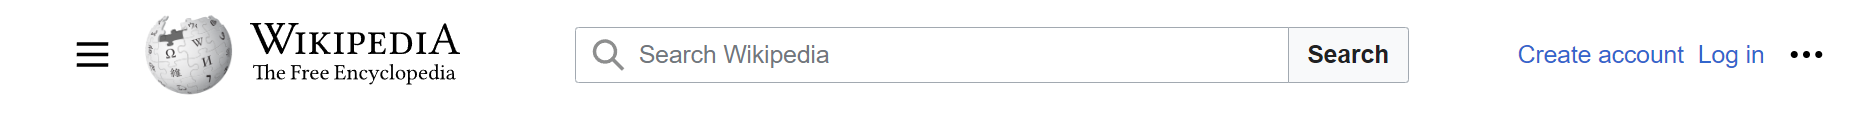

#Marie Curie

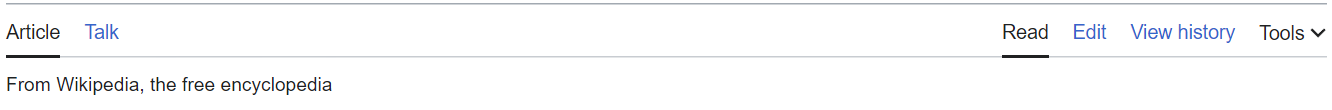

Fuair Marie Curie, a rugadh i Warsaw, Congress Poland, Russian Empire ar 07 Samhain 1867, bás i bPassy, Haute-Savoie, France. Is é a ainm breithe ná Maria Salomea Skłodowska agus is páistí di iad Ève Curie agus Irène Joliot-Curie. 



In [37]:
from IPython.display import Image, display, Markdown

display(Image('/content/triples2predArg/wikipedia-header.png', width=1400, height=82))
title = '#'+name+''
display(Markdown(title))
display(Image('/content/triples2predArg/wikipedia-subheader.png', width=1110, height=82))

with codecs.open(filename, 'r', 'utf-8') as text:
  for line in text:
    print(line)